# Minería de texto: clasificación de artículos

### Autor: Silvia García Hernández                                                                    
### Fecha: 3/06/2019

In [ ]:
from pybtex.database.input import bibtex

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
import pickle 
import time
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import AgglomerativeClustering
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.manifold import TSNE

from nltk.cluster import KMeansClusterer, cosine_distance
from scipy.spatial.distance import cosine

from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
datos_original = pd.read_csv("artciles.csv")    # Lectura archivo .csv

datos_original.head()   

,entry,title,keywords,abstract,year,journal
0,AZAZA20181,Context proposals for saliency detection,"Computational saliency, Object segmentation, O...",One of the fundamental properties of a salient...,2018,Computer Vision and Image Understanding
1,BENSHABAT201812,Graph based over-segmentation methods for 3D p...,"3D point cloud over-segmentation, 3D point clo...","Over-segmentation, or super-pixel generation, ...",2018,Computer Vision and Image Understanding
2,YANG201843,Text effects transfer via distribution-aware t...,"Text effects, Texture synthesis, Spatial distr...","In this paper, we explore the problem of fanta...",2018,Computer Vision and Image Understanding
3,BARATH201870,Efficient energy-based topological outlier rej...,"Stereo vision, Outlier filtering, Energy minim...",An approach is proposed for outlier rejection ...,2018,Computer Vision and Image Understanding
4,ARRIGONI201895,Robust synchronization in SO(3) and SE(3) via ...,"Absolute rotations, Global rotations, Structur...",This paper deals with the synchronization prob...,2018,Computer Vision and Image Understanding


In [3]:
datos_original.groupby(['journal']).count()

,entry,title,keywords,abstract,year
journal,,,,,
Computer Vision and Image Understanding,249,249,249,249,249
Data & Knowledge Engineering,99,99,99,99,99
Journal of Visual Communication and Image Representation,433,433,433,433,433


In [4]:
interestFieldT = datos_original[['title','journal']]
interestFieldK = datos_original[['keywords','journal']]
interestFieldA = datos_original[['abstract','journal']]

interestFields = [[interestFieldT, interestFieldK, interestFieldA]]
pd.DataFrame(interestFields[0][0]).head()

,title,journal
0,Context proposals for saliency detection,Computer Vision and Image Understanding
1,Graph based over-segmentation methods for 3D p...,Computer Vision and Image Understanding
2,Text effects transfer via distribution-aware t...,Computer Vision and Image Understanding
3,Efficient energy-based topological outlier rej...,Computer Vision and Image Understanding
4,Robust synchronization in SO(3) and SE(3) via ...,Computer Vision and Image Understanding


In [5]:
for i in range(3):
    interestFields[0][i] = interestFields[0][i].replace({'journal': 'Computer Vision and Image Understanding'}, 
                                            {'journal': 0}, regex=True)
    interestFields[0][i] = interestFields[0][i].replace({'journal': 'Journal of Visual Communication and Image Representation'}, 
                                            {'journal': 1}, regex=True)
    interestFields[0][i] = interestFields[0][i].replace({'journal': 'Data & Knowledge Engineering'}, 
                                            {'journal': 2}, regex=True)
pd.DataFrame(interestFields[0][0]).head()

,title,journal
0,Context proposals for saliency detection,0
1,Graph based over-segmentation methods for 3D p...,0
2,Text effects transfer via distribution-aware t...,0
3,Efficient energy-based topological outlier rej...,0
4,Robust synchronization in SO(3) and SE(3) via ...,0


In [6]:
for i in range(3):
    interestFields[0][i] = interestFields[0][i].sort_values(by ='journal')
    
pd.DataFrame(interestFields[0][0]).head()

,title,journal
0,Context proposals for saliency detection,0
232,Efficient tree-structured SfM by RANSAC genera...,0
231,Error-aware construction and rendering of mult...,0
586,Segmentation of clusters by template rotation ...,0
587,Recognising complex activities with histograms...,0


In [7]:
titlesList = interestFields[0][0]['title'].tolist()
keysList = interestFields[0][1]['keywords'].tolist()
abstractsList = interestFields[0][2]['abstract'].tolist()

sentencesList = [[titlesList, keysList, abstractsList]]
len(sentencesList[0])

3

In [8]:
classList = interestFields[0][0]['journal'].tolist()
len(classList)

781

## Remove Punctuation Signs

In [9]:
tokenizer = RegexpTokenizer(r'\w+')

for i in range(len(sentencesList[0])):
    for sentence in range(len(sentencesList[0][i])):
        tokens = tokenizer.tokenize(sentencesList[0][i][sentence])
        sentencesList[0][i][sentence] = " ".join(tokens)
        
pd.DataFrame(sentencesList[0][0]).head()

,0
0,Context proposals for saliency detection
1,Efficient tree structured SfM by RANSAC genera...
2,Error aware construction and rendering of mult...
3,Segmentation of clusters by template rotation ...
4,Recognising complex activities with histograms...


In [10]:
pnt = str.maketrans('', '', string.punctuation)

for i in range(len(sentencesList[0])):
    sentencesList[0][i] = [" ".join([word.translate(pnt) for word in doc.split()]) 
                           for doc in sentencesList[0][i]]
    
pd.DataFrame(sentencesList[0][0]).head()

,0
0,Context proposals for saliency detection
1,Efficient tree structured SfM by RANSAC genera...
2,Error aware construction and rendering of mult...
3,Segmentation of clusters by template rotation ...
4,Recognising complex activities with histograms...


## Lemmatization

In [11]:
lemmer = nltk.stem.WordNetLemmatizer()

for i in range(len(sentencesList[0])):
    sentencesList[0][i] = [" ".join([lemmer.lemmatize(word) for word in doc.split()]) 
                           for doc in sentencesList[0][i]]
    
pd.DataFrame(sentencesList[0][0]).head()

,0
0,Context proposal for saliency detection
1,Efficient tree structured SfM by RANSAC genera...
2,Error aware construction and rendering of mult...
3,Segmentation of cluster by template rotation e...
4,Recognising complex activity with histogram of...


## Stemming (elegir entre Porter o SnowBall)

In [12]:
porter = PorterStemmer()

for i in range(len(sentencesList[0])):
    sentencesList[0][i] = [" ".join([porter.stem(word) for word in doc.split()]) 
                           for doc in sentencesList[0][i]]

pd.DataFrame(sentencesList[0][0]).head()

,0
0,context propos for salienc detect
1,effici tree structur sfm by ransac gener procr...
2,error awar construct and render of multi scan ...
3,segment of cluster by templat rotat expect maxim
4,recognis complex activ with histogram of rel t...


In [12]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)

for i in range(len(sentencesList[0])):
    sentencesList[0][i] = [" ".join([stemmer.stem(word) for word in doc.split()]) 
                      for doc in sentencesList[0][i]]

pd.DataFrame(sentencesList[0][0]).head()

,0
0,context propos for salienc detect
1,effici tree structur sfm by ransac general pro...
2,error awar construct and render of multi scan ...
3,segment of cluster by templat rotat expect maxim
4,recognis complex activ with histogram of relat...


## Delete words with 3 letters or less

In [13]:
shortword = re.compile(r'\W*\b\w{1,3}\b')

for i in range(len(sentencesList[0])):
    for sentence in range(len(sentencesList[0][i])):
        sentencesList[0][i][sentence] = shortword.sub('', sentencesList[0][i][sentence])

pd.DataFrame(sentencesList[0][0]).head()

,0
0,context propos salienc detect
1,effici tree structur ransac general procrust a...
2,error awar construct render multi scan panoram...
3,segment cluster templat rotat expect maxim
4,recognis complex activ with histogram relat tr...


# Extracción de características

## TF-IDF (elegir entre Hashing, TF o TF-IDF)

In [14]:
tfidf = TfidfVectorizer(stop_words = 'english',
        sublinear_tf = True,
        strip_accents = 'ascii',
        analyzer = 'word',
        token_pattern = r'\w{3,}',  #vectorize 2-character words or more
        ngram_range = (1, 3),
        max_features = 800,
        max_df = 0.7)

docTrans0 = tfidf.fit_transform(sentencesList[0][0])
docTrans1 = tfidf.fit_transform(sentencesList[0][1])
docTrans2 = tfidf.fit_transform(sentencesList[0][2])

tfidf_matrix_list = [[docTrans0, docTrans1, docTrans2]]

#print(tfidf.get_feature_names())
#print("")
#print(tfidf.get_params())
#print("")
#print(tfidf.get_stop_words())
#print("")
#print(len(interestFieldsTokensSWords))     #samples, features
#print(tfidf.vocabulary_)
#print(tfidf.idf_)

weights = np.asarray(tfidf_matrix_list[0][2].mean(axis = 0)).ravel().tolist()
weights_df = pd.DataFrame({'Término': tfidf.get_feature_names(), 'Peso': weights})
weights_df.sort_values(by = 'Peso', ascending = False).head()

,Término,Peso
339,imag,0.056000
430,method,0.050679
58,base,0.039986
441,model,0.037147
277,featur,0.035324


In [15]:
pd.DataFrame(tfidf_matrix_list[0][2].toarray(), columns=tfidf.get_feature_names()).head()

,abil,accord,account,accur,accuraci,achiev,acquir,action,action recognit,activ,...,weak,weight,wide,window,word,work,work propos,world,year,yield
0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.083849,0.0,0.0,0.0,0.0
2,0.0,0.0,0.113256,0.09149,0.000000,0.072503,0.131424,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.076979,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.00000,0.088922,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.183356,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## CountVectorizer (TF)

In [17]:
tf = CountVectorizer(stop_words = 'english',
        strip_accents = 'ascii',
        analyzer = 'word',
        token_pattern = r'\w{3,}',  #vectorize 2-character words or more
        ngram_range = (1, 3),
        max_features = 800,
        max_df = 0.7)

docTrans0 = tf.fit_transform(sentencesList[0][0])
docTrans1 = tf.fit_transform(sentencesList[0][1])
docTrans2 = tf.fit_transform(sentencesList[0][2])

tfidf_matrix_list = [[docTrans0, docTrans1, docTrans2]]

weights = np.asarray(docTrans2.mean(axis = 0)).ravel().tolist()
weights_df = pd.DataFrame({'Término': tf.get_feature_names(), 'Peso': weights})
weights_df.sort_values(by = 'Peso', ascending = False).head()

,Término,Peso
335,imag,2.044814
428,method,1.701665
57,base,1.129321
439,model,0.956466
273,featur,0.850192


## Hashing 

In [18]:
hashing = HashingVectorizer(n_features = 500, stop_words = 'english')

docTrans00 = hashing.fit_transform(sentencesList[0][0])
docTrans11 = hashing.fit_transform(sentencesList[0][1])
docTrans22 = hashing.fit_transform(sentencesList[0][2])

tfidf_matrix_list = [[docTrans00, docTrans11, docTrans22]]

# Reducción de características

## LSA (elegir entre LSA o LDA)

In [19]:
print("El número de atributos calculados con TF-IDF es: %d" % docTrans0.get_shape()[1])

print("\n---Reducción de dimensionalidad con LSA---")

t0 = time.time()

svd = TruncatedSVD(n_components = 500, n_iter = 100, random_state = 42)
normalizer = Normalizer(copy = False)
lsa = make_pipeline(svd, normalizer)

tfidf_matrix_lsa0 = lsa.fit_transform(tfidf_matrix_list[0][0])
tfidf_matrix_lsa1 = lsa.fit_transform(tfidf_matrix_list[0][1])
tfidf_matrix_lsa2 = lsa.fit_transform(tfidf_matrix_list[0][2])

tfidf_matrix_lsa = [[tfidf_matrix_lsa0, tfidf_matrix_lsa1, tfidf_matrix_lsa2]]

print("Ha llevado %.3f segundos" % (time.time() - t0))

variance_lsa = svd.explained_variance_ratio_.sum()

print("Cantidad de información contenida en LSA (varianza): {}%".format(int(variance_lsa * 100)))

El número de atributos calculados con TF-IDF es: 800

---Reducción de dimensionalidad con LSA---
Ha llevado 7.405 segundos
Cantidad de información contenida en LSA (varianza): 97%


## LDA

In [20]:
print("El número de atributos calculados con TF-IDF es: %d" % docTrans0.get_shape()[1])

print("\n---Reducción de dimensionalidad con LDA---")

t0 = time.time()

lda = LatentDirichletAllocation(n_components = 500, learning_method = 'online', random_state = 0, verbose = 0)

tfidf_matrix_lda0 = lda.fit_transform(tfidf_matrix_list[0][0])
tfidf_matrix_lda1 = lda.fit_transform(tfidf_matrix_list[0][1])
tfidf_matrix_lda2 = lda.fit_transform(tfidf_matrix_list[0][2])

tfidf_matrix_lda = [[tfidf_matrix_lda0, tfidf_matrix_lda1, tfidf_matrix_lda2]]

print("Ha llevado %.3f segundos" % (time.time() - t0))

El número de atributos calculados con TF-IDF es: 800

---Reducción de dimensionalidad con LDA---
Ha llevado 22.647 segundos


# Clustering

## Kmeans + LSA

In [21]:
for i in range(len(tfidf_matrix_lsa[0])):
    kmeans = KMeans(n_clusters = 3, random_state = 0, max_iter = 1000).fit(tfidf_matrix_lsa[0][i])

    print("Homogeneity: %0.3f" % metrics.homogeneity_score(np.array(classList), kmeans.labels_))
    print("Completeness: %0.3f" % metrics.completeness_score(np.array(classList), kmeans.labels_))
    print("V-measure: %0.3f" % metrics.v_measure_score(np.array(classList), kmeans.labels_))
    print("Adjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(np.array(classList), kmeans.labels_))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(tfidf_matrix_lsa[0][i], kmeans.labels_, sample_size=1000))
    print("")

Homogeneity: 0.042
Completeness: 0.040
V-measure: 0.041
Adjusted Rand-Index: 0.033
Silhouette Coefficient: 0.009

Homogeneity: 0.021
Completeness: 0.025
V-measure: 0.023
Adjusted Rand-Index: 0.045
Silhouette Coefficient: 0.013

Homogeneity: 0.206
Completeness: 0.180
V-measure: 0.192
Adjusted Rand-Index: 0.136
Silhouette Coefficient: 0.011



## Kmeans + LDA

In [22]:
for i in range(len(tfidf_matrix_lda[0])):
    kmeans = KMeans(n_clusters = 3, random_state = 0, max_iter = 1000).fit(tfidf_matrix_lda[0][i])

    print("Homogeneity: %0.3f" % metrics.homogeneity_score(np.array(classList), kmeans.labels_))
    print("Completeness: %0.3f" % metrics.completeness_score(np.array(classList), kmeans.labels_))
    print("V-measure: %0.3f" % metrics.v_measure_score(np.array(classList), kmeans.labels_))
    print("Adjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(np.array(classList), kmeans.labels_))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(tfidf_matrix_lda[0][i], kmeans.labels_, sample_size=1000))
    print("")

Homogeneity: 0.045
Completeness: 0.043
V-measure: 0.044
Adjusted Rand-Index: 0.042
Silhouette Coefficient: 0.280

Homogeneity: 0.006
Completeness: 0.006
V-measure: 0.006
Adjusted Rand-Index: 0.001
Silhouette Coefficient: 0.366

Homogeneity: 0.044
Completeness: 0.041
V-measure: 0.042
Adjusted Rand-Index: 0.049
Silhouette Coefficient: 0.528



## MiniBatchKMeans + LSA

In [23]:
for i in range(len(tfidf_matrix_lsa[0])):    
    kmeansmini = MiniBatchKMeans(n_clusters=3, random_state=0, batch_size=6).fit(tfidf_matrix_lsa[0][i])

    print("Homogeneity: %0.3f" % metrics.homogeneity_score(np.array(classList), kmeansmini.labels_))
    print("Completeness: %0.3f" % metrics.completeness_score(np.array(classList), kmeansmini.labels_))
    print("V-measure: %0.3f" % metrics.v_measure_score(np.array(classList), kmeansmini.labels_))
    print("Adjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(np.array(classList), kmeansmini.labels_))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(tfidf_matrix_lsa[0][i], kmeansmini.labels_, sample_size=1000))
    print("")

Homogeneity: 0.002
Completeness: 0.113
V-measure: 0.005
Adjusted Rand-Index: -0.000
Silhouette Coefficient: -0.008

Homogeneity: 0.002
Completeness: 0.023
V-measure: 0.004
Adjusted Rand-Index: -0.006
Silhouette Coefficient: -0.014

Homogeneity: 0.102
Completeness: 0.329
V-measure: 0.155
Adjusted Rand-Index: 0.096
Silhouette Coefficient: 0.005



## MiniBatchKMeans + LDA

In [24]:
for i in range(len(tfidf_matrix_lda[0])):    
    kmeansmini = MiniBatchKMeans(n_clusters=3, random_state=0, batch_size=6).fit(tfidf_matrix_lda[0][i])

    print("Homogeneity: %0.3f" % metrics.homogeneity_score(np.array(classList), kmeansmini.labels_))
    print("Completeness: %0.3f" % metrics.completeness_score(np.array(classList), kmeansmini.labels_))
    print("V-measure: %0.3f" % metrics.v_measure_score(np.array(classList), kmeansmini.labels_))
    print("Adjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(np.array(classList), kmeansmini.labels_))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(tfidf_matrix_lda[0][i], kmeansmini.labels_, sample_size=1000))
    print("")

Homogeneity: 0.041
Completeness: 0.042
V-measure: 0.042
Adjusted Rand-Index: 0.078
Silhouette Coefficient: 0.304

Homogeneity: 0.018
Completeness: 0.017
V-measure: 0.018
Adjusted Rand-Index: 0.019
Silhouette Coefficient: 0.418

Homogeneity: 0.041
Completeness: 0.041
V-measure: 0.041
Adjusted Rand-Index: 0.053
Silhouette Coefficient: 0.507



## Agglomerative (Hierarchical + cosine) + LSA

In [25]:
for i in range(len(tfidf_matrix_lsa[0])):
    HAC = AgglomerativeClustering(n_clusters = 3, affinity = 'cosine', linkage = 'average').fit(tfidf_matrix_lda[0][i])  
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(np.array(classList), HAC.labels_))
    print("Completeness: %0.3f" % metrics.completeness_score(np.array(classList), HAC.labels_))
    print("V-measure: %0.3f" % metrics.v_measure_score(np.array(classList), HAC.labels_))
    print("Adjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(np.array(classList), HAC.labels_))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(tfidf_matrix_lda[0][i], HAC.labels_, sample_size=1000))
    print("")

Homogeneity: 0.001
Completeness: 0.011
V-measure: 0.002
Adjusted Rand-Index: 0.001
Silhouette Coefficient: 0.230

Homogeneity: 0.003
Completeness: 0.150
V-measure: 0.006
Adjusted Rand-Index: 0.002
Silhouette Coefficient: 0.542

Homogeneity: 0.017
Completeness: 0.033
V-measure: 0.023
Adjusted Rand-Index: 0.012
Silhouette Coefficient: 0.546



## Kmeans (cosine distance) + LSA 

In [26]:
kcluster = KMeansClusterer(3, distance = cosine_distance, repeats = 5)

for i in range(len(tfidf_matrix_lsa[0])):
    assigned_clusters = kcluster.cluster(tfidf_matrix_lsa[0][i], assign_clusters = True)

    print("Homogeneity: %0.3f" % metrics.homogeneity_score(np.array(classList), assigned_clusters))
    print("Completeness: %0.3f" % metrics.completeness_score(np.array(classList), assigned_clusters))
    print("V-measure: %0.3f" % metrics.v_measure_score(np.array(classList), assigned_clusters))
    print("Adjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(np.array(classList), assigned_clusters))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(tfidf_matrix_lsa[0][i], assigned_clusters, sample_size=1000))
    print("")

Homogeneity: 0.012
Completeness: 0.011
V-measure: 0.012
Adjusted Rand-Index: 0.002
Silhouette Coefficient: 0.007

Homogeneity: 0.104
Completeness: 0.093
V-measure: 0.098
Adjusted Rand-Index: 0.097
Silhouette Coefficient: 0.011

Homogeneity: 0.169
Completeness: 0.148
V-measure: 0.158
Adjusted Rand-Index: 0.096
Silhouette Coefficient: 0.009



## TSNE (visualización)

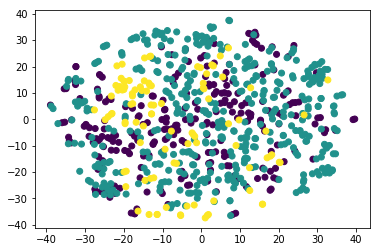

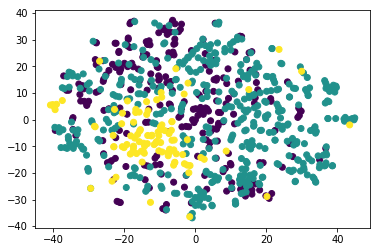

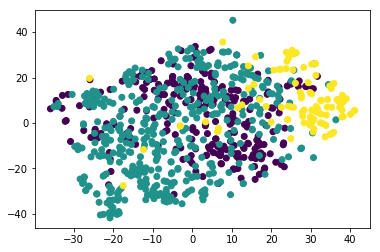

In [27]:
tsne = TSNE(learning_rate = 100)

for i in range(len(tfidf_matrix_lsa[0])):
    transformedTSNE = tsne.fit_transform(tfidf_matrix_lsa[0][i])

    x_axis = transformedTSNE[:, 0]
    y_axis = transformedTSNE[:, 1]

    plt.scatter(x_axis, y_axis, c = np.array(classList))
    plt.show()

# Clasificación

## TF-IDF

In [30]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(sentencesList[0][0], np.array(classList), 
                                                    test_size = 0.3, random_state = 42)
X_train1, X_test1, y_train1, y_test1 = train_test_split(sentencesList[0][1], np.array(classList), 
                                                    test_size = 0.3, random_state = 42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(sentencesList[0][2], np.array(classList), 
                                                    test_size = 0.3, random_state = 42)

X_train_tfidf0 = tfidf.fit_transform(X_train0)
X_train_tfidf1 = tfidf.fit_transform(X_train1)
X_train_tfidf2 = tfidf.fit_transform(X_train2)

X_train_tfidf = [[X_train_tfidf0, X_train_tfidf1, X_train_tfidf2]]

X_test_tfidf0 = tfidf.transform(X_test0)
X_test_tfidf1 = tfidf.transform(X_test1)
X_test_tfidf2 = tfidf.transform(X_test2)

X_test_tfidf = [[X_test_tfidf0, X_test_tfidf1, X_test_tfidf2]]

y_train = [[y_train0, y_train1, y_train2]]
y_test = [[y_test0, y_test1, y_test2]]

## TF

In [ ]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(sentencesList[0][0], np.array(classList), 
                                                    test_size = 0.3, random_state = 42)
X_train1, X_test1, y_train1, y_test1 = train_test_split(sentencesList[0][1], np.array(classList), 
                                                    test_size = 0.3, random_state = 42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(sentencesList[0][2], np.array(classList), 
                                                    test_size = 0.3, random_state = 42)

X_train_tfidf0 = tf.fit_transform(X_train0)
X_train_tfidf1 = tf.fit_transform(X_train1)
X_train_tfidf2 = tf.fit_transform(X_train2)

X_train_tfidf = [[X_train_tfidf0, X_train_tfidf1, X_train_tfidf2]]

X_test_tfidf0 = tf.transform(X_test0)
X_test_tfidf1 = tf.transform(X_test1)
X_test_tfidf2 = tf.transform(X_test2)

X_test_tfidf = [[X_test_tfidf0, X_test_tfidf1, X_test_tfidf2]]

y_train = [[y_train0, y_train1, y_train2]]
y_test = [[y_test0, y_test1, y_test2]]

## LSA

In [31]:
print("El número de atributos calculados con TF-IDF es: %d" % X_train_tfidf0.get_shape()[1])

print("\n---Reducción de dimensionalidad con LSA---")

t0 = time.time()

svd = TruncatedSVD(n_components=300, n_iter=100, random_state=42, algorithm="arpack")
lsa = make_pipeline(svd, Normalizer(copy=False))

X_train_lsa0 = lsa.fit_transform(X_train_tfidf0)
X_train_lsa1 = lsa.fit_transform(X_train_tfidf1)
X_train_lsa2 = lsa.fit_transform(X_train_tfidf2)

X_train_lsa = [[X_train_lsa0, X_train_lsa1, X_train_lsa2]]

print("Ha llevado %.3f segundos" % (time.time() - t0))

X_test_lsa0 = lsa.transform(X_test_tfidf0)
X_test_lsa1 = lsa.transform(X_test_tfidf1)
X_test_lsa2 = lsa.transform(X_test_tfidf2)

X_test_lsa = [[X_test_lsa0, X_test_lsa1, X_test_lsa2]]

variance_lsa = svd.explained_variance_ratio_.sum()

print("Cantidad de información contenida en LSA (varianza): {}%".format(int(variance_lsa * 100)))

El número de atributos calculados con TF-IDF es: 800

---Reducción de dimensionalidad con LSA---
Ha llevado 0.743 segundos
Cantidad de información contenida en LSA (varianza): 89%


## LDA

In [32]:
print("---Reducción de dimensionalidad con LDA---")

t0 = time.time()

lda = LatentDirichletAllocation(n_components = 300, learning_method = 'batch', random_state = 0, verbose = 0)

X_train_lda0 = lda.fit_transform(X_train_tfidf0)
X_train_lda1 = lda.fit_transform(X_train_tfidf1)
X_train_lda2 = lda.fit_transform(X_train_tfidf2)

X_train_lda = [[X_train_lda0, X_train_lda1, X_train_lda2]]

print("Ha llevado %.3f segundos" % (time.time() - t0))

X_test_lda0 = lda.transform(X_test_tfidf0)
X_test_lda1 = lda.transform(X_test_tfidf1)
X_test_lda2 = lda.transform(X_test_tfidf2)

X_test_lda = [[X_test_lda0, X_test_lda1, X_test_lda2]]

---Reducción de dimensionalidad con LDA---
Ha llevado 7.057 segundos


## Complement ND 

In [33]:
clf = ComplementNB(alpha = 3.0, class_prior = [0.5, 0.17, 0.33], norm = True)

for i in range(len(X_train_tfidf[0])):
    clf.fit(X_train_tfidf[0][i], y_train[0][i])
    y_pred = clf.predict(X_test_tfidf[0][i])
    resultado_ND = metrics.accuracy_score(y_pred, y_test[0][i]) 

    print("%0.8f" % resultado_ND)

0.33617021
0.44255319
0.77872340


## PassiveAggressiveClassifier

In [34]:
clfp = PassiveAggressiveClassifier(max_iter = 1000, random_state = 42, tol = 1e-5)
    
for i in range(len(X_train_tfidf[0])):
    clfp.fit(X_train_tfidf[0][i], y_train[0][i])
    y_pred = clfp.predict(X_test_tfidf[0][i])
    resultado_PAC = metrics.accuracy_score(y_pred, y_test[0][i]) 

    print("%0.8f" % resultado_PAC)

0.46382979
0.45957447
0.72765957


## PassiveAggressiveClassifier + LSA

In [35]:
clfp = PassiveAggressiveClassifier(max_iter = 1000, random_state = 42, tol = 1e-5)
    
for i in range(len(X_train_tfidf[0])):
    clfp.fit(X_train_lsa[0][i], y_train[0][i])
    y_pred = clfp.predict(X_test_lsa[0][i])
    resultado_PAC_LSA = metrics.accuracy_score(y_pred, y_test[0][i]) 

    print("%0.8f" % resultado_PAC_LSA)

0.48936170
0.38723404
0.68936170


## PassiveAggressiveClassifier + LDA

In [36]:
clfp = PassiveAggressiveClassifier(max_iter = 1000, random_state = 0, tol = 1e-3)
    
for i in range(len(X_train_tfidf[0])):
    clfp.fit(X_train_lda[0][i], y_train[0][i])
    y_pred = clfp.predict(X_test_lda[0][i])
    resultado_PAC_LDA = metrics.accuracy_score(y_pred, y_test[0][i]) 

    print("%0.8f" % resultado_PAC_LDA)

0.55319149
0.55319149
0.55319149


## SGDClassifier

In [37]:
clfs = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)

for i in range(len(X_train_tfidf[0])):
    clfs.fit(X_train_tfidf[0][i], y_train[0][i])
    y_pred = clfs.predict(X_test_tfidf[0][i])
    resultado_SGD = metrics.accuracy_score(y_pred, y_test[0][i]) 

    print("%0.8f" % resultado_SGD)

0.46808511
0.46382979
0.71489362


## SGDClassifier + LSA

In [38]:
clfs = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)

for i in range(len(X_train_tfidf[0])):
    clfs.fit(X_train_lsa[0][i], y_train[0][i])
    y_pred = clfs.predict(X_test_lsa[0][i])
    resultado_SGD_LSA = metrics.accuracy_score(y_pred, y_test[0][i]) 

    print("%0.8f" % resultado_SGD_LSA)

0.47659574
0.38297872
0.71914894


## SGDClassifier + LDA

In [39]:
clfs = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)

for i in range(len(X_train_tfidf[0])):
    clfs.fit(X_train_lda[0][i], y_train[0][i])
    y_pred = clfs.predict(X_test_lda[0][i])
    resultado_SGD_LDA = metrics.accuracy_score(y_pred, y_test[0][i]) 

    print("%0.8f" % resultado_SGD_LDA)

0.55319149
0.55319149
0.57446809


## SVC

In [40]:
from sklearn.svm import LinearSVC

clfv = LinearSVC(random_state=42, tol=1e-9, C=4, max_iter=10000)

for i in range(len(X_train_tfidf[0])):
    clfv.fit(X_train_tfidf[0][i], y_train[0][i])
    y_pred = clfv.predict(X_test_tfidf[0][i])
    resultado_SVC = metrics.accuracy_score(y_pred, y_test[0][i]) 

    print("%0.8f" % resultado_SVC)

0.48936170
0.48085106
0.74042553


## SVC + LSA

In [41]:
from sklearn.svm import LinearSVC

clfv = LinearSVC(random_state=42, tol=1e-9, C=4, max_iter=10000)

for i in range(len(X_train_tfidf[0])):
    clfv.fit(X_train_lsa[0][i], y_train[0][i])
    y_pred = clfv.predict(X_test_lsa[0][i])
    resultado_SVC_LSA = metrics.accuracy_score(y_pred, y_test[0][i]) 

    print("%0.8f" % resultado_SVC_LSA)

0.47234043
0.37021277
0.71489362


## SVC + LDA

In [42]:
clfv = LinearSVC(random_state=42, tol=1e-5, C=3, max_iter=5000)

for i in range(len(X_train_tfidf[0])):
    clfv.fit(X_train_lda[0][i], y_train[0][i])
    y_pred = clfv.predict(X_test_lda[0][i])
    resultado_SVC_LDA = metrics.accuracy_score(y_pred, y_test[0][i]) 

    print("%0.8f" % resultado_SVC_LDA)

0.55319149
0.55319149
0.62127660


## RandomForest

In [43]:


clfr = RandomForestClassifier(n_estimators=500, max_depth=100,random_state=0)

for i in range(len(X_train_tfidf[0])):
    clfr.fit(X_train_tfidf[0][i], y_train[0][i])
    y_pred = clfr.predict(X_test_tfidf[0][i])
    resultado_RF = metrics.accuracy_score(y_pred, y_test[0][i]) 

    print("%0.8f" % resultado_RF)

0.55744681
0.54042553
0.71489362


## RandomForest + LSA

In [44]:
clfr = RandomForestClassifier(n_estimators=500, max_depth=100,random_state=0)

for i in range(len(X_train_tfidf[0])):
    clfr.fit(X_train_lsa[0][i], y_train[0][i])
    y_pred = clfr.predict(X_test_lsa[0][i])
    resultado_RF_LSA = metrics.accuracy_score(y_pred, y_test[0][i]) 

    print("%0.8f" % resultado_RF_LSA)

0.55319149
0.55744681
0.64680851


## Logistic Regresion 

In [45]:
cllr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')

for i in range(len(X_train_tfidf[0])):
    cllr.fit(X_train_tfidf[0][i], y_train[0][i])
    y_pred = cllr.predict(X_test_tfidf[0][i])
    resultado_RF = metrics.accuracy_score(y_pred, y_test[0][i]) 

    print("%0.8f" % resultado_RF)

0.54468085
0.53617021
0.78723404


## Logistic Regresion + LSA

In [46]:
cllr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')

for i in range(len(X_train_tfidf[0])):
    cllr.fit(X_train_lsa[0][i], y_train[0][i])
    y_pred = cllr.predict(X_test_lsa[0][i])
    resultado_RF = metrics.accuracy_score(y_pred, y_test[0][i]) 

    print("%0.8f" % resultado_RF)

0.50638298
0.45957447
0.77446809
